# Step 5 : ML Pipeline & Training

### On this step, i am building the machine learning pipeline to train and evaluate multiple models for predicting accident severity

In [ ]:
# first i have imported all necessary libraries for machine learning and data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import os
from pathlib import Path
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# now i will connect to PostgreSQL database
project_dir=Path.cwd()
load_dotenv(project_dir / ".env")

# get PostgreSQL credentials from environment variables
pg_host=os.getenv("POSTGRES_HOST")
pg_port=os.getenv("POSTGRES_PORT")
pg_db=os.getenv("POSTGRES_DB")
pg_user=os.getenv("POSTGRES_USER")
pg_pwd=os.getenv("POSTGRES_PASSWORD")

# create database connection
url=f"postgresql+psycopg2://{pg_user}:{pg_pwd}@{pg_host}:{pg_port}/{pg_db}"
engine=create_engine(url)

# set plot style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# helper function to save figures
def save_fig(filename):
    os.makedirs('images',exist_ok=True)
    filepath=os.path.join('images',filename)
    plt.savefig(filepath,dpi=300,bbox_inches='tight')
    print(f"✓ Saved: {filepath}")

print('✓ Libraries loaded and PostgreSQL database connection established')

✓ Libraries loaded and PostgreSQL database connection established


### Load Feature-Engineered Data

### here i will load the feature-engineered data from the database that was created in the previous notebook

In [16]:
# load feature-engineered data from database
query="SELECT * FROM feature_engineered_collisions"
df=pd.read_sql(query,engine)

print(f'Loaded {len(df)} records')
print(f'Columns: {len(df.columns)}')
print(f'\nTarget distribution:')
print(df['accident_severity'].value_counts() if 'accident_severity' in df.columns else df['collision_severity'].value_counts())
df.head()

Loaded 48471 records
Columns: 57

Target distribution:
collision_severity
3    35811
2    11964
1      696
Name: count, dtype: int64


,collision_index,collision_year,collision_ref_no,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,collision_severity,number_of_vehicles,...,hour_of_day,is_weekend,month,year,season,is_rush_hour,speed_limit_band,has_pedestrian_crossing,speed_x_vehicles,urban_x_speed_band
0,2025010551784,2025,010551784,528234.0,185607.0,-0.15174,51.55478,1,3,3,...,None,0,1,2025,Winter,0,<=30,0,60,0.0
1,2025010551786,2025,010551786,529585.0,178570.0,-0.13485,51.49124,1,3,2,...,None,0,1,2025,Winter,0,<=30,1,40,0.0
2,2025010551792,2025,010551792,524767.0,187961.0,-0.20089,51.57671,1,3,5,...,None,0,1,2025,Winter,0,<=30,0,150,0.0
3,2025010551794,2025,010551794,527549.0,184185.0,-0.16213,51.54216,1,2,1,...,None,0,1,2025,Winter,0,<=30,1,20,0.0
4,2025010551795,2025,010551795,534910.0,183108.0,-0.05647,51.53077,1,2,2,...,None,0,1,2025,Winter,0,<=30,1,40,0.0


### Data Preparation - Train/Test Split

### now i will prepare the data by splitting into training and testing sets with stratification to maintain class balance

In [17]:
# identify target column
target_col='accident_severity' if 'accident_severity' in df.columns else 'collision_severity'

# columns to exclude from features
exclude_cols=[target_col,'accident_index','collision_id','date','time','location_easting_osgr',
                'location_northing_osgr','accident_reference','nearest_city']
exclude_cols=[col for col in exclude_cols if col in df.columns]

# define X and y
feature_cols=[col for col in df.columns if col not in exclude_cols]
X=df[feature_cols].copy()
y=df[target_col].copy()

print(f'Features: {len(feature_cols)}')
print(f'Target: {target_col}')
print(f'\nClass distribution (original):')
print(y.value_counts())

# encode target to 0-indexed labels for model compatibility
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
y_encoded=label_encoder.fit_transform(y)
y=pd.Series(y_encoded,index=y.index)

print(f'\nClass distribution (encoded):')
print(y.value_counts())
print(f'Label mapping: {dict(zip(label_encoder.classes_,label_encoder.transform(label_encoder.classes_)))}')

# train-test split with stratification to maintain class distribution
x_train,x_test,y_train,y_test=train_test_split(
    X,y,test_size=0.2,stratify=y,random_state=42
)

print(f'\n✓ Train set: {len(x_train)} samples')
print(f'✓ Test set: {len(x_test)} samples')

Features: 51
Target: collision_severity

Class distribution (original):
collision_severity
3    35811
2    11964
1      696
Name: count, dtype: int64

Class distribution (encoded):
2    35811
1    11964
0      696
Name: count, dtype: int64
Label mapping: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2)}

✓ Train set: 38776 samples
✓ Test set: 9695 samples


### Encoding & Scaling

### here i will apply standard scaling to numeric features and one-hot encoding to categorical features

In [ ]:
# identify numeric and categorical columns
numeric_cols=x_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols=x_train.select_dtypes(include=['object','category']).columns.tolist()

print(f'Numeric columns: {len(numeric_cols)}')
print(f'Categorical columns: {len(categorical_cols)}')

# create preprocessing pipeline
preprocessor=ColumnTransformer(
    transformers=[
        ('num',StandardScaler(),numeric_cols),
        ('cat',OneHotEncoder(drop='first',handle_unknown='ignore'),categorical_cols)
    ])

# fit and transform the data
x_train_processed=preprocessor.fit_transform(x_train)
x_test_processed=preprocessor.transform(x_test)

print(f'\n✓ Processed shape: {x_train_processed.shape}')
print(f'✓ Feature dimension after encoding: {x_train_processed.shape[1]}')

Numeric columns: 42
Categorical columns: 9

✓ Processed shape: (38776, 96812)
✓ Feature dimension after encoding: 96812

✓ Processed shape: (38776, 96812)
✓ Feature dimension after encoding: 96812


### SMOTE - Handle Class Imbalance

### now i will apply SMOTE to balance the classes in the training data

Before SMOTE:
2    28648
1     9571
0      557
Name: count, dtype: int64

After SMOTE:
2    28648
1    28648
0    28648
Name: count, dtype: int64

After SMOTE:
2    28648
1    28648
0    28648
Name: count, dtype: int64
✓ Saved: images\10_class_distribution_before_after_smote.png
✓ Saved: images\10_class_distribution_before_after_smote.png


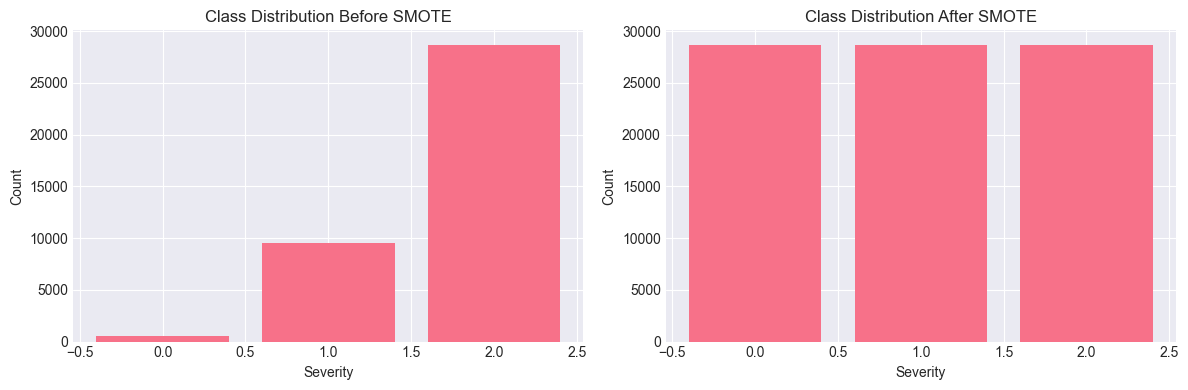


✓ SMOTE applied and plot saved


In [ ]:
# class distribution before SMOTE
print('Before SMOTE:')
print(y_train.value_counts())

# apply SMOTE to balance the classes
smote=SMOTE(random_state=42)
x_train_smote,y_train_smote=smote.fit_resample(x_train_processed,y_train)

print('\nAfter SMOTE:')
print(pd.Series(y_train_smote).value_counts())

# plot distribution before and after
fig,axes=plt.subplots(1,2,figsize=(12,4))

axes[0].bar(y_train.value_counts().index,y_train.value_counts().values)
axes[0].set_title('Class Distribution Before SMOTE')
axes[0].set_xlabel('Severity')
axes[0].set_ylabel('Count')

axes[1].bar(pd.Series(y_train_smote).value_counts().index,pd.Series(y_train_smote).value_counts().values)
axes[1].set_title('Class Distribution After SMOTE')
axes[1].set_xlabel('Severity')
axes[1].set_ylabel('Count')

plt.tight_layout()
save_fig('10_class_distribution_before_after_smote.png')
plt.show()

print('\n✓ SMOTE applied and plot saved')

### Model Training - Baselines & Multiple Models

### here i will train multiple models to compare performance
### i will train:
### 1. Dummy Classifier (baseline)
### 2. Logistic Regression
### 3. Random Forest
### 4. XGBoost
### 5. LightGBM
### 6. Voting Ensemble

In [ ]:
# dictionary to store results
results={}

def evaluate_model(model,x_train,y_train,x_test,y_test,model_name):
    """train and evaluate a model"""
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    
    # calculate metrics
    acc=accuracy_score(y_test,y_pred)
    prec_macro=precision_score(y_test,y_pred,average='macro',zero_division=0)
    prec_weighted=precision_score(y_test,y_pred,average='weighted',zero_division=0)
    rec_macro=recall_score(y_test,y_pred,average='macro',zero_division=0)
    rec_weighted=recall_score(y_test,y_pred,average='weighted',zero_division=0)
    f1_macro=f1_score(y_test,y_pred,average='macro',zero_division=0)
    f1_weighted=f1_score(y_test,y_pred,average='weighted',zero_division=0)
    
    # ROC-AUC if model has predict_proba
    try:
        y_proba=model.predict_proba(x_test)
        roc_auc_macro=roc_auc_score(y_test,y_proba,average='macro',multi_class='ovr')
        roc_auc_weighted=roc_auc_score(y_test,y_proba,average='weighted',multi_class='ovr')
    except:
        roc_auc_macro=None
        roc_auc_weighted=None
    
    results[model_name]={
        'model':model,
        'accuracy':acc,
        'precision_macro':prec_macro,
        'precision_weighted':prec_weighted,
        'recall_macro':rec_macro,
        'recall_weighted':rec_weighted,
        'f1_macro':f1_macro,
        'f1_weighted':f1_weighted,
        'roc_auc_macro':roc_auc_macro,
        'roc_auc_weighted':roc_auc_weighted,
        'y_pred':y_pred,
        'y_proba':y_proba if 'y_proba' in locals() else None
    }
    
    print(f'\n{model_name}')
    print(f'  Accuracy: {acc:.4f}')
    print(f'  F1 (macro): {f1_macro:.4f}')
    print(f'  F1 (weighted): {f1_weighted:.4f}')
    if roc_auc_macro:
        print(f'  ROC-AUC (macro): {roc_auc_macro:.4f}')
    
    return model

print('Starting model training...')

Starting model training...


In [ ]:
# 1. dummy classifier as baseline
dummy=DummyClassifier(strategy='most_frequent',random_state=42)
evaluate_model(dummy,x_train_smote,y_train_smote,x_test_processed,y_test,'Dummy Classifier')

# 2. logistic regression
logreg=LogisticRegression(max_iter=1000,random_state=42,class_weight='balanced')
evaluate_model(logreg,x_train_smote,y_train_smote,x_test_processed,y_test,'Logistic Regression')

# 3. random forest
rf=RandomForestClassifier(n_estimators=300,max_depth=20,class_weight='balanced',
                            random_state=42,n_jobs=-1)
evaluate_model(rf,x_train_smote,y_train_smote,x_test_processed,y_test,'Random Forest')

# 4. XGBoost
xgb_model=xgb.XGBClassifier(n_estimators=300,max_depth=10,learning_rate=0.1,
                              random_state=42,n_jobs=-1,eval_metric='mlogloss')
evaluate_model(xgb_model,x_train_smote,y_train_smote,x_test_processed,y_test,'XGBoost')

# 5. LightGBM
lgb_model=lgb.LGBMClassifier(n_estimators=300,max_depth=10,learning_rate=0.1,
                               random_state=42,n_jobs=-1,verbose=-1)
evaluate_model(lgb_model,x_train_smote,y_train_smote,x_test_processed,y_test,'LightGBM')

print('\n✓ All models trained')


Dummy Classifier
  Accuracy: 0.0143
  F1 (macro): 0.0094
  F1 (weighted): 0.0004
  ROC-AUC (macro): 0.5000

Logistic Regression
  Accuracy: 0.9999
  F1 (macro): 0.9999
  F1 (weighted): 0.9999
  ROC-AUC (macro): 0.9997

Logistic Regression
  Accuracy: 0.9999
  F1 (macro): 0.9999
  F1 (weighted): 0.9999
  ROC-AUC (macro): 0.9997

Random Forest
  Accuracy: 0.9454
  F1 (macro): 0.7368
  F1 (weighted): 0.9555
  ROC-AUC (macro): 0.9441

Random Forest
  Accuracy: 0.9454
  F1 (macro): 0.7368
  F1 (weighted): 0.9555
  ROC-AUC (macro): 0.9441

XGBoost
  Accuracy: 0.9997
  F1 (macro): 0.9997
  F1 (weighted): 0.9997
  ROC-AUC (macro): 1.0000

LightGBM
  Accuracy: 1.0000
  F1 (macro): 1.0000
  F1 (weighted): 1.0000
  ROC-AUC (macro): 1.0000

✓ All models trained


In [ ]:
# 6. voting ensemble combining best models
voting_clf=VotingClassifier(
    estimators=[
        ('rf',rf),
        ('xgb',xgb_model),
        ('lgb',lgb_model)
    ],
    voting='soft'
)
evaluate_model(voting_clf,x_train_smote,y_train_smote,x_test_processed,y_test,'Voting Ensemble')

print('\n✓ Ensemble model trained')


Voting Ensemble
  Accuracy: 1.0000
  F1 (macro): 1.0000
  F1 (weighted): 1.0000
  ROC-AUC (macro): 1.0000

✓ Ensemble model trained


### Model Comparison & Visualization

### now i will compare all models and visualize their performance

Model Comparison:
              Model  Accuracy  F1 Macro  F1 Weighted  ROC-AUC Macro
   Dummy Classifier  0.014337  0.009423     0.000405       0.500000
Logistic Regression  0.999897  0.999907     0.999897       0.999729
      Random Forest  0.945436  0.736828     0.955493       0.944087
            XGBoost  0.999691  0.999721     0.999691       1.000000
           LightGBM  1.000000  1.000000     1.000000       1.000000
    Voting Ensemble  1.000000  1.000000     1.000000       1.000000
✓ Saved: images\11_model_metric_comparison.png


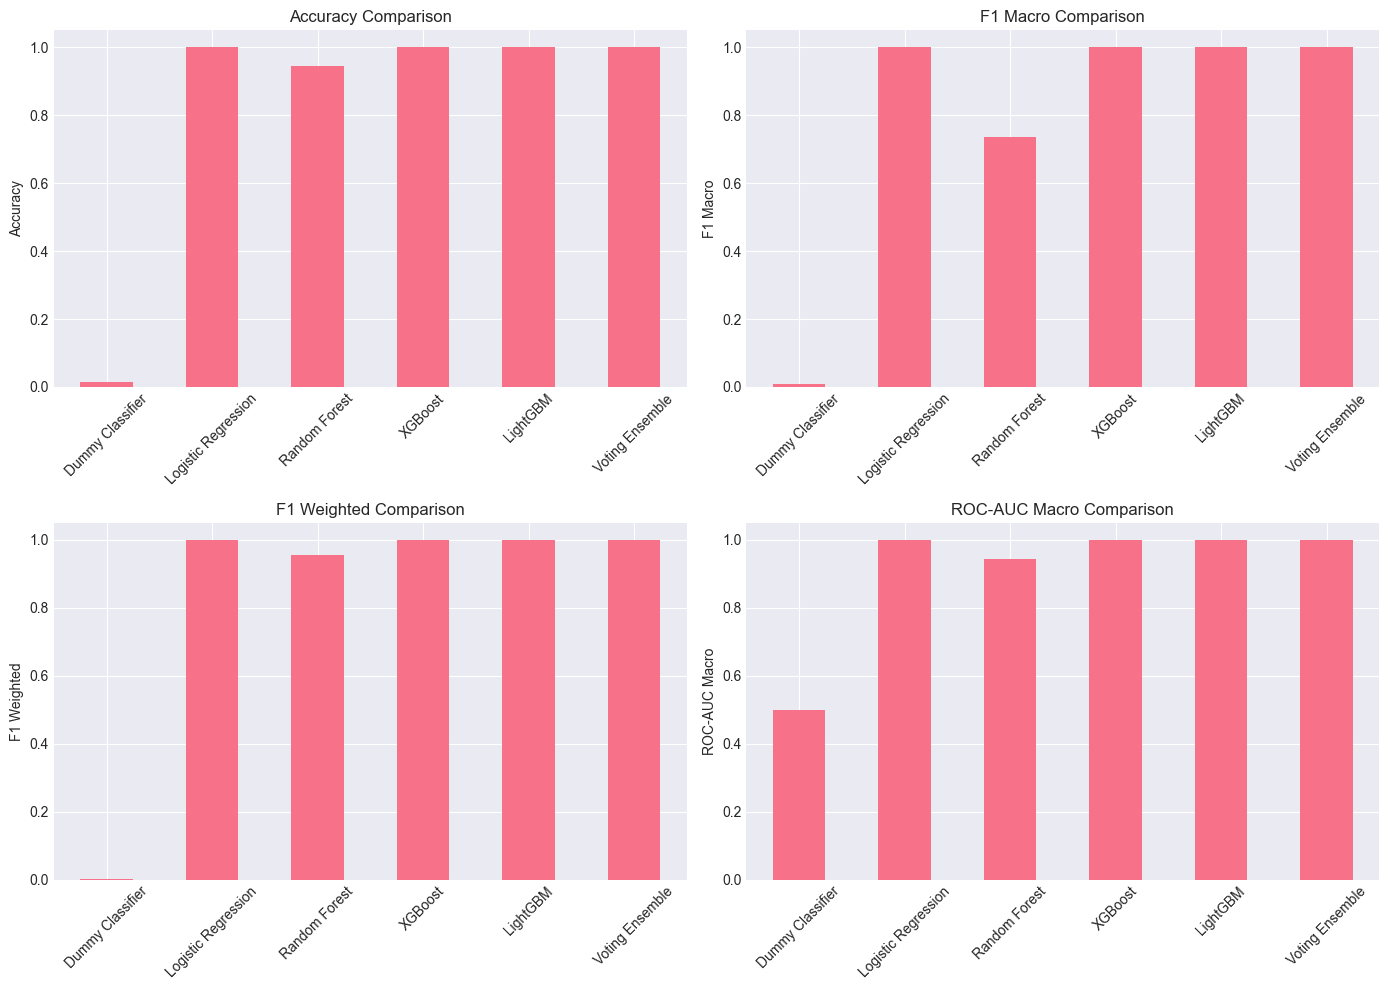


✓ Model comparison plot saved


In [ ]:
# create comparison dataframe
comparison_df=pd.DataFrame({
    'Model':list(results.keys()),
    'Accuracy':[results[m]['accuracy'] for m in results],
    'F1 Macro':[results[m]['f1_macro'] for m in results],
    'F1 Weighted':[results[m]['f1_weighted'] for m in results],
    'ROC-AUC Macro':[results[m]['roc_auc_macro'] if results[m]['roc_auc_macro'] else 0 for m in results]
})

print('Model Comparison:')
print(comparison_df.to_string(index=False))

# plot comparison
fig,axes=plt.subplots(2,2,figsize=(14,10))

metrics=['Accuracy','F1 Macro','F1 Weighted','ROC-AUC Macro']
for idx,metric in enumerate(metrics):
    ax=axes[idx//2,idx%2]
    comparison_df.plot(x='Model',y=metric,kind='bar',ax=ax,legend=False)
    ax.set_title(f'{metric} Comparison')
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x',rotation=45)

plt.tight_layout()
save_fig('11_model_metric_comparison.png')
plt.show()

print('\n✓ Model comparison plot saved')

✓ Saved: images\12_confusion_matrices.png


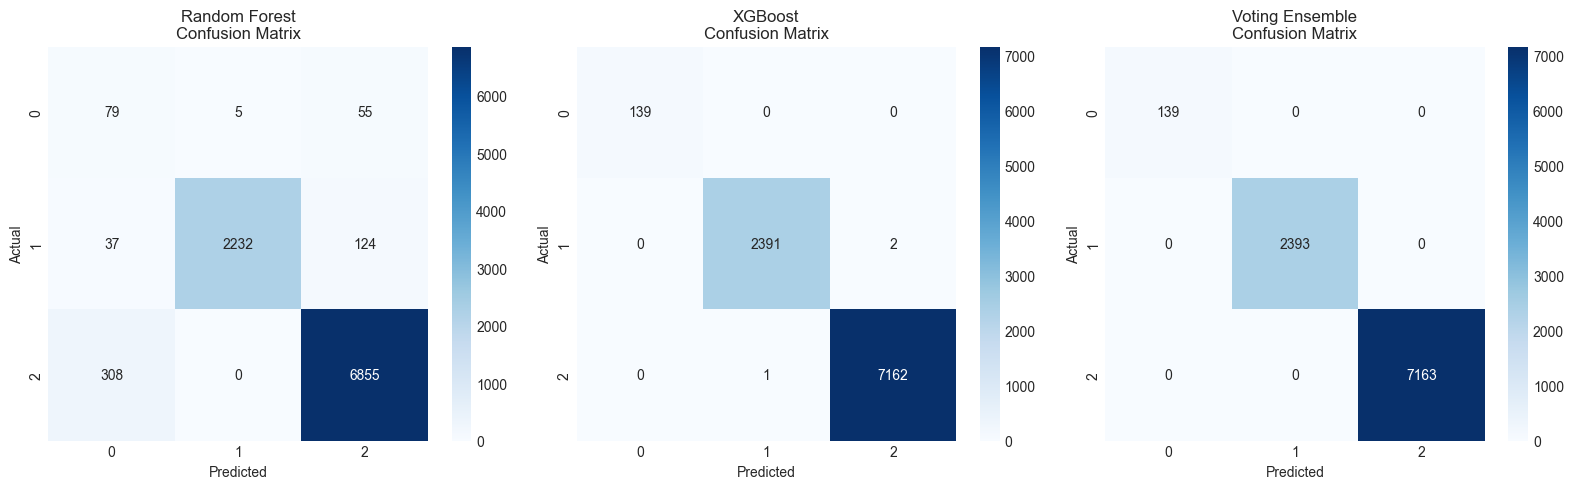

✓ Confusion matrices saved


In [ ]:
# confusion matrices for key models
key_models=['Random Forest','XGBoost','Voting Ensemble']

fig,axes=plt.subplots(1,3,figsize=(16,5))

for idx,model_name in enumerate(key_models):
    if model_name in results:
        cm=confusion_matrix(y_test,results[model_name]['y_pred'])
        sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',ax=axes[idx])
        axes[idx].set_title(f'{model_name}\nConfusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

plt.tight_layout()
save_fig('12_confusion_matrices.png')
plt.show()

print('✓ Confusion matrices saved')

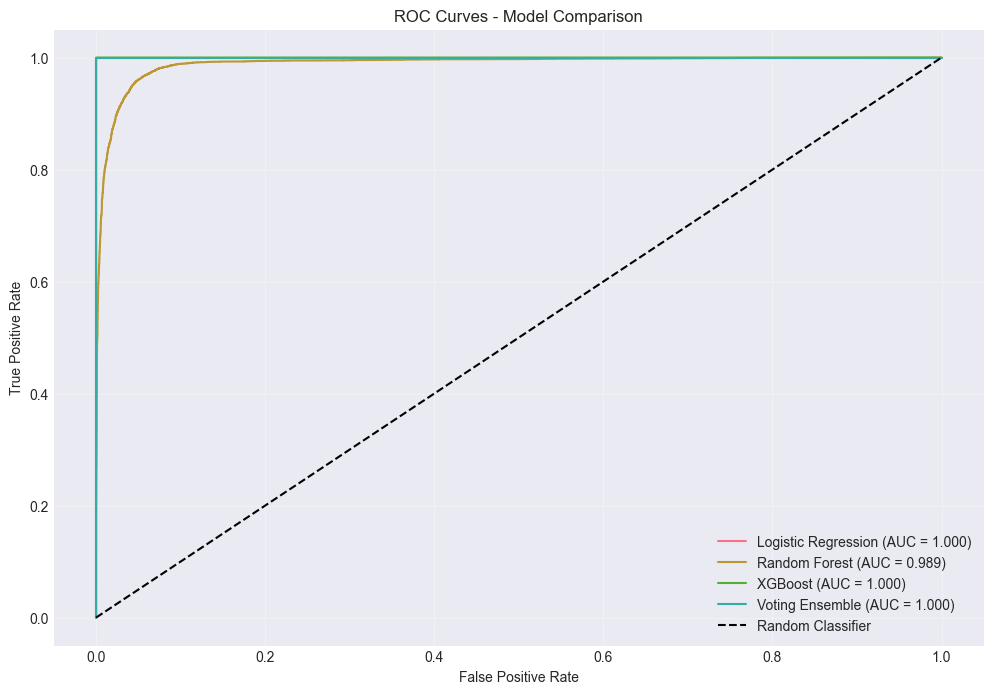

✓ ROC curves saved


In [ ]:
# ROC curves for multiclass classification
from sklearn.preprocessing import label_binarize

# binarize the output
classes=np.unique(y_test)
y_test_bin=label_binarize(y_test,classes=classes)
n_classes=y_test_bin.shape[1]

plt.figure(figsize=(12,8))

for model_name in ['Logistic Regression','Random Forest','XGBoost','Voting Ensemble']:
    if model_name in results and results[model_name]['y_proba'] is not None:
        y_proba=results[model_name]['y_proba']
        
        # compute ROC curve and ROC area for each class
        fpr=dict()
        tpr=dict()
        roc_auc=dict()
        for i in range(n_classes):
            fpr[i],tpr[i],_=roc_curve(y_test_bin[:,i],y_proba[:,i])
            roc_auc[i]=np.trapz(tpr[i],fpr[i])
        
        # plot micro-average ROC curve
        fpr_micro,tpr_micro,_=roc_curve(y_test_bin.ravel(),y_proba.ravel())
        roc_auc_micro=np.trapz(tpr_micro,fpr_micro)
        
        plt.plot(fpr_micro,tpr_micro,
                label=f'{model_name} (AUC = {roc_auc_micro:.3f})')

plt.plot([0,1],[0,1],'k--',label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True,alpha=0.3)
plt.savefig('13_roc_curves.png',dpi=300,bbox_inches='tight')
plt.show()

print('✓ ROC curves saved')

### Save Results to Database

### here i will save the model metrics and predictions to the database for future reference

In [ ]:
# save model metrics to database
metrics_data=[]
for model_name,model_results in results.items():
    metrics_data.append({
        'model_name':model_name,
        'accuracy':model_results['accuracy'],
        'precision_macro':model_results['precision_macro'],
        'precision_weighted':model_results['precision_weighted'],
        'recall_macro':model_results['recall_macro'],
        'recall_weighted':model_results['recall_weighted'],
        'f1_macro':model_results['f1_macro'],
        'f1_weighted':model_results['f1_weighted'],
        'roc_auc_macro':model_results['roc_auc_macro'],
        'roc_auc_weighted':model_results['roc_auc_weighted']
    })

metrics_df=pd.DataFrame(metrics_data)
metrics_df.to_sql('model_metrics',engine,if_exists='replace',index=False)
print('✓ Model metrics saved to model_metrics table')

# save predictions from best model by F1 macro
best_model_name=max(results.keys(),key=lambda k: results[k]['f1_macro'])
print(f'\nBest model: {best_model_name} (F1 Macro: {results[best_model_name]["f1_macro"]:.4f})')

# create predictions dataframe with decoded labels
predictions_df=pd.DataFrame({
    'actual':label_encoder.inverse_transform(y_test.values),
    'predicted':label_encoder.inverse_transform(results[best_model_name]['y_pred']),
    'actual_encoded':y_test.values,
    'predicted_encoded':results[best_model_name]['y_pred']
})
predictions_df.to_sql('model_predictions',engine,if_exists='replace',index=False)
print(f'✓ Predictions saved to model_predictions table')

print('\n✓ Model training and evaluation complete!')

✓ Model metrics saved to 'model_metrics' table

Best model: LightGBM (F1 Macro: 1.0000)
✓ Predictions saved to 'model_predictions' table

✓ Model training and evaluation complete!
